![](img/330-banner.png)

# Lecture 5: Preprocessing and `sklearn` pipelines

UBC 2022 Summer

Instructor: Mehrdad Oveisi

## Imports

In [2]:
import sys
import time

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")

import mglearn
from IPython.display import display
from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

pd.set_option("display.max_colwidth", 200)

## Learning outcomes

From this lecture, you will be able to 

- explain motivation for preprocessing in supervised machine learning;
- identify when to implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline; 
- use `sklearn` transformers for applying feature transformations on your dataset;
- discuss golden rule in the context of feature transformations;
- use `sklearn.pipeline.Pipeline` and `sklearn.pipeline.make_pipeline` to build a preliminary machine learning pipeline. 

## Motivation and big picture [[video](https://youtu.be/xx9HlmzORRk)]

- So far we have seen
    - Three ML models (decision trees, $k$-NNs, SVMs with RBF kernel)
    - ML fundamentals (train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule)
- Are we ready to do machine learning on real-world datasets?
    - Very often real-world datasets need preprocessing before we use them to build ML models. 

### Example: $k$-nearest neighbours on the Spotify dataset

- In lab1 you used `DecisionTreeClassifier` to predict whether the user would like a particular song or not. 
- Can we use $k$-NN classifier for this task? 
- Intuition: To predict whether the user likes a particular song or not (query point) 
   - find the songs that are closest to the query point
   - let them vote on the target
   - take the majority vote as the target for the query point
   

In [3]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
train_df, test_df = train_test_split(spotify_df, test_size=0.20, random_state=123)
X_train, y_train = (
    train_df.drop(columns=["song_title", "artist", "target"]),
    train_df["target"],
)
X_test, y_test = (
    test_df.drop(columns=["song_title", "artist", "target"]),
    test_df["target"],
)

In [4]:
dummy = DummyClassifier(strategy="most_frequent")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.508


,fit_time,score_time,test_score,train_score
0,0.001393,0.000885,0.507740,0.507752
1,0.001201,0.000465,0.507740,0.507752
2,0.001693,0.000444,0.507740,0.507752
3,0.001152,0.000287,0.506211,0.508133
4,0.000700,0.000593,0.509317,0.507359


In [5]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.546


,fit_time,score_time,test_score,train_score
0,0.006364,0.013621,0.563467,0.717829
1,0.002828,0.008317,0.535604,0.721705
2,0.002573,0.008169,0.529412,0.708527
3,0.002580,0.008737,0.537267,0.721921
4,0.002859,0.008458,0.562112,0.711077


In [6]:
two_songs = X_train.sample(2, random_state=42)
two_songs

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
842,0.229000,0.494,147893,0.666,0.000057,9,0.0469,-9.743,0,0.0351,140.832,4.0,0.704
654,0.000289,0.771,227143,0.949,0.602000,8,0.5950,-4.712,1,0.1750,111.959,4.0,0.372


In [7]:
euclidean_distances(two_songs)

array([[    0.        , 79250.00543825],
       [79250.00543825,     0.        ]])

Let's consider only two features: `duration_ms` and `tempo`.

In [8]:
two_songs_subset = two_songs[["duration_ms", "tempo"]]
two_songs_subset

,duration_ms,tempo
842,147893,140.832
654,227143,111.959


In [9]:
euclidean_distances(two_songs_subset)

array([[    0.        , 79250.00525962],
       [79250.00525962,     0.        ]])

Do you see any problem? 

- The distance is completely **dominated** by the the features with **larger values**
- The features with smaller values are being ignored. 
- Does it matter? 
    - Yes! Scale is based on how data was collected. 
    - Features on a smaller scale can be highly informative and there is no good reason to ignore them.
    - We want our model to **be robust and not sensitive to the scale**.
- Was this a problem for decision trees?


### Scaling using `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- We'll use `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which is a `transformer`.   
- Only focus on the syntax for now. We'll talk about scaling in a bit. 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # create feature trasformer object
scaler.fit(X_train)  # fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)  # transforming the train split
X_test_scaled = scaler.transform(X_test)  # transforming the test split
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,-0.697633,-0.194548,-0.398940,-0.318116,-0.492359,1.275623,-0.737898,0.395794,-1.280599,-0.617752,-0.293827,0.138514,-0.908149
1,-0.276291,0.295726,-0.374443,-0.795552,0.598355,-1.487342,-0.438792,-0.052394,0.780884,2.728394,-0.802595,-3.781179,-1.861238
2,-0.599540,1.110806,-0.376205,-0.946819,-0.492917,0.446734,-0.399607,-0.879457,0.780884,2.534909,0.191274,0.138514,0.575870
3,-0.307150,1.809445,-0.654016,-1.722063,-0.492168,0.170437,-0.763368,-1.460798,-1.280599,-0.608647,-0.839616,0.138514,1.825358
4,-0.634642,0.491835,-0.131344,1.057468,2.723273,0.170437,-0.458384,-0.175645,-1.280599,-0.653035,-0.074294,0.138514,-0.754491


### `fit` and `transform` paradigm for transformers
- `sklearn` uses `fit` and `transform` paradigms for feature transformations. 
- We `fit` the transformer on the train split and then transform the train split as well as the test split. 
- We apply the same transformations on the test split. 

### `sklearn` API summary: estimators

Suppose `model` is a classification or regression model. 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)
```    


### `sklearn` API summary: transformers

Suppose `transformer` is a transformer used to change the input representation, for example, to tackle missing values or to scales numeric features.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```  

- You can pass `y_train` in `fit` but it's usually ignored. It allows you to pass it just to be consistent with usual usage of `sklearn`'s `fit` method.   
- You can also carry out fitting and transforming in one call using `fit_transform`. But be mindful to use it only on the train split and **not** on the test split. 

- Do you expect `DummyClassifier` results to change after scaling the data? 
- Let's check whether scaling makes any difference for $k$-NNs. 

In [11]:
knn_unscaled = KNeighborsClassifier()
knn_unscaled.fit(X_train, y_train)
print("Train score: %0.3f" % (knn_unscaled.score(X_train, y_train)))
print("Test score: %0.3f" % (knn_unscaled.score(X_test, y_test)))

Train score: 0.726
Test score: 0.552


In [12]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train)
print("Train score: %0.3f" % (knn_scaled.score(X_train_scaled, y_train)))
print("Test score: %0.3f" % (knn_scaled.score(X_test_scaled, y_test)))

Train score: 0.798
Test score: 0.686


- The scores with scaled data are better compared to the unscaled data in case of $k$-NNs.
- I am not carrying out cross-validation here for a reason that we'll look into soon. 
- Note that I am a bit sloppy here and using the test set several times for teaching purposes. But when you build an ML pipeline, please do assessment on the test set only once.  

### Common preprocessing techniques

Some commonly performed feature transformation include:  
- **Imputation**: Tackling missing values
- **Scaling**: Scaling of numeric features
- **One-hot encoding**: Tackling categorical variables      
    

We can have one lecture on each of them! In this lesson our goal is to getting familiar with them so that we can use them to build ML pipelines. 

In the next part of this lecture, we'll build an ML pipeline using [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing). In the process, we will talk about different feature transformations and how can we apply them so that we do not violate the golden rule. 

<br><br><br><br>

## Imputation and scaling [[video](https://youtu.be/G2IXbVzKlt8)]

### Dataset, splitting, and baseline

We'll be working on [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing) to demonstrate these feature transformation techniques. The task is to predict median house values in Californian districts, given a number of features from these districts. If you are running the notebook on your own, you'll have to download the data and put it in the data directory. 

In [13]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


Some column values are mean/median but some are not. 

Let's add some new features to the dataset which could help predicting the target: `median_house_value`. 

In [14]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [15]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


### When is it OK to do things before splitting? 

- Here it would have been OK to add new features before splitting because we are not using any **global information** in the data but only looking at **one row at a time**.
- But just to be safe and to avoid accidentally breaking the golden rule, it's **better to do it after splitting**.

- Question: Should we remove `total_rooms`, `total_bedrooms`, and `population` columns? 
    - Probably. But I am keeping them in this lecture. You could experiment with removing them and examine whether results change. 

### Exploratory Data Analysis (EDA)

In [16]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


We see that the feature **scales** are quite different. 

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   total_rooms               18576 non-null  float64
 4   total_bedrooms            18391 non-null  float64
 5   population                18576 non-null  float64
 6   households                18576 non-null  float64
 7   median_income             18576 non-null  float64
 8   median_house_value        18576 non-null  float64
 9   ocean_proximity           18576 non-null  object 
 10  rooms_per_household       18576 non-null  float64
 11  bedrooms_per_household    18391 non-null  float64
 12  population_per_household  18576 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


We have one **categorical** feature and all other features are **numeric** features. 

In [18]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,population_per_household
count,18576.000000,18576.000000,18576.000000,18576.000000,18391.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18391.000000,18576.000000
mean,-119.565888,35.627966,28.622255,2635.749677,538.229786,1428.578165,500.061100,3.862552,206292.067991,5.426067,1.097516,3.052349
std,1.999622,2.134658,12.588307,2181.789934,421.805266,1141.664801,383.044313,1.892491,115083.856175,2.512319,0.486266,10.020873
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.333333,0.692308
25%,-121.790000,33.930000,18.000000,1449.000000,296.000000,788.000000,280.000000,2.560225,119400.000000,4.439360,1.005888,2.430323
50%,-118.490000,34.250000,29.000000,2127.000000,435.000000,1167.000000,410.000000,3.527500,179300.000000,5.226415,1.048860,2.818868
75%,-118.010000,37.710000,37.000000,3145.000000,647.000000,1727.000000,606.000000,4.736900,263600.000000,6.051620,1.099723,3.283921
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,34.066667,1243.333333


In [19]:
train_df.describe().loc['count']

longitude                   18576.0
latitude                    18576.0
housing_median_age          18576.0
total_rooms                 18576.0
total_bedrooms              18391.0
population                  18576.0
households                  18576.0
median_income               18576.0
median_house_value          18576.0
rooms_per_household         18576.0
bedrooms_per_household      18391.0
population_per_household    18576.0
Name: count, dtype: float64

- Seems like `total_bedrooms` column has some missing values. 
- This must have affected our new feature `bedrooms_per_household` as well. 

In [20]:
housing_df["total_bedrooms"].isnull().sum()

207

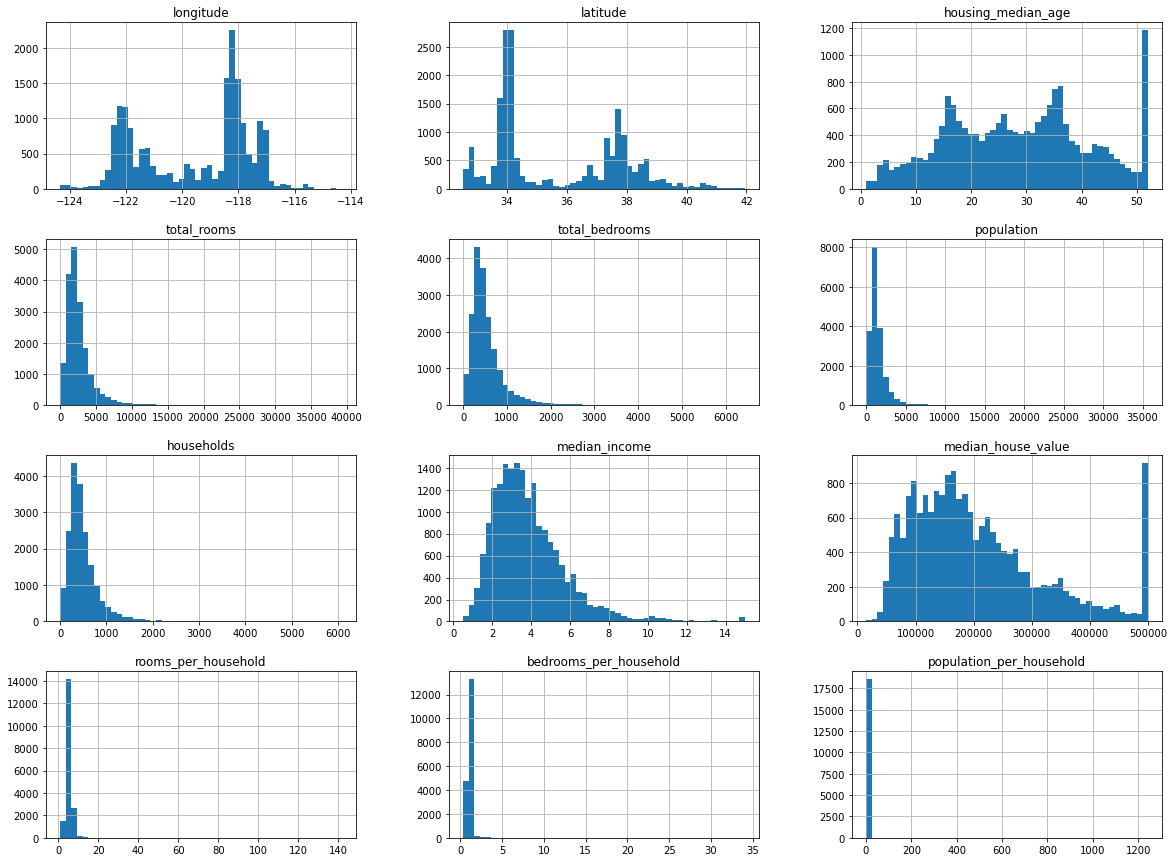

In [21]:
## (optional)
train_df.hist(bins=50, figsize=(20, 15));

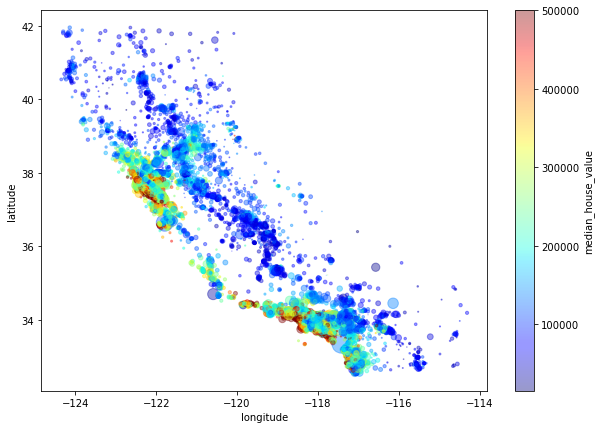

In [22]:
## (optional)
train_df.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=train_df["population"] / 100,
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
);

### What all transformations we need to apply on the dataset? 

Here is what we see from the EDA. 

- Some missing values in `total_bedrooms` column
- Scales are quite different across columns. 
- Categorical variable `ocean_proximity`

Read about [preprocessing techniques implemented in `scikit-learn`](https://scikit-learn.org/stable/modules/preprocessing.html).  

We are dropping the categorical variable `ocean_proximity` for now. We'll come back to it in a bit.

In [23]:
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

### Let's first run our baseline model `DummyRegressor`

In [24]:
results_dict = {}  # dictionary to store our results for different models

In [25]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [26]:
dummy = DummyRegressor(strategy="median")
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True
)

In [27]:
pd.DataFrame(results_dict)

,dummy
fit_time,0.002 (+/- 0.000)
score_time,0.000 (+/- 0.000)
test_score,-0.055 (+/- 0.012)
train_score,-0.055 (+/- 0.001)


### Imputation 

In [28]:
knn = KNeighborsRegressor()
# knn.fit(X_train, y_train)  # This call gives ValueError

### What's the problem? 

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```

- The classifier is not able to deal with **missing values** (NaN).
- What are possible ways to deal with the problem?
    - **Delete** the rows? 
    - **Replace** them with some reasonable values?    

- `SimpleImputer` is a transformer in `sklearn` to deal with this problem. For example, 
    - You can impute missing values in **categorical** columns with the **most frequent** value.
    - You can impute the missing values in **numeric** columns with the **mean** or **median** of the column.    

In [29]:
X_train.sort_values("bedrooms_per_household")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
20248,-119.23,34.25,28.0,26.0,3.0,29.0,9.0,8.0000,2.888889,0.333333,3.222222
12649,-121.47,38.51,52.0,20.0,4.0,74.0,9.0,3.6250,2.222222,0.444444,8.222222
3125,-117.76,35.22,4.0,18.0,3.0,8.0,6.0,1.6250,3.000000,0.500000,1.333333
12138,-117.22,33.87,16.0,56.0,7.0,39.0,14.0,2.6250,4.000000,0.500000,2.785714
8219,-118.21,33.79,33.0,32.0,18.0,96.0,36.0,4.5938,0.888889,0.500000,2.666667
...,...,...,...,...,...,...,...,...,...,...,...
4591,-118.28,34.06,42.0,2472.0,NaN,3795.0,1179.0,1.2254,2.096692,NaN,3.218830
19485,-120.98,37.66,10.0,934.0,NaN,401.0,255.0,0.9336,3.662745,NaN,1.572549
6962,-118.05,33.99,38.0,1619.0,NaN,886.0,357.0,3.7328,4.535014,NaN,2.481793
14970,-117.01,32.74,31.0,3473.0,NaN,2098.0,677.0,2.6973,5.129985,NaN,3.098966


In [30]:
X_train.shape, X_test.shape

((18576, 11), (2064, 11))

In [31]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

- Let's check whether the NaN values have been replaced or not
- Note that `imputer.transform` returns an `numpy` array and not a dataframe

In [32]:
pd.DataFrame(X_train_imp, columns=X_train.columns).describe().loc['count']

longitude                   18576.0
latitude                    18576.0
housing_median_age          18576.0
total_rooms                 18576.0
total_bedrooms              18576.0
population                  18576.0
households                  18576.0
median_income               18576.0
rooms_per_household         18576.0
bedrooms_per_household      18576.0
population_per_household    18576.0
Name: count, dtype: float64

### Scaling 

##### - This problem affects a large number of ML methods.
- A number of approaches to this problem. We are going to look into **two most popular** ones.

| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| normalization | sets range to $[0,1]$   | `X -= np.min(X,axis=0)`<br>`X /= np.max(X,axis=0)`  | [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

There are all sorts of articles on this; see, e.g. [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

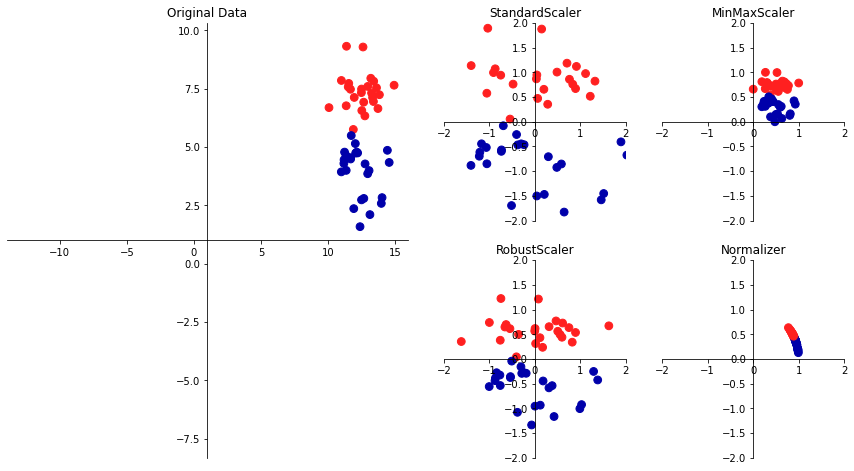

In [33]:
# [source](https://amueller.github.io/COMS4995-s19/slides/aml-05-preprocessing/#8)
mglearn.plots.plot_scaling()

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
0,0.908140,-0.743917,-0.526078,0.143120,0.235339,1.026092,0.266135,-0.389736,-0.210591,-0.083813,0.126398
1,-0.002057,1.083123,-0.923283,-1.049510,-0.969959,-1.206672,-1.253312,-0.198924,4.726412,11.166631,-0.050132
2,1.218207,-1.352930,1.380504,0.329670,0.549764,0.024896,0.542873,-0.635239,-0.273606,-0.025391,-0.099240
3,1.128188,-0.753286,-0.843842,-0.459154,-0.626949,-0.463877,-0.561467,0.714077,0.122307,-0.280310,0.010183
4,1.168196,-1.287344,-0.843842,1.343085,2.210026,4.269688,2.500924,-1.059242,-0.640266,-0.190617,0.126808
...,...,...,...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.875337,-0.243446,-0.822136,-0.966131,-0.118182,0.063110,-0.099558,0.071541
18572,1.163195,-1.057793,-1.161606,0.940194,0.609314,0.882438,0.728235,0.357500,0.235096,-0.163397,0.007458
18573,-1.097293,0.797355,-1.876574,0.695434,0.433046,0.881563,0.514155,0.934269,0.211892,-0.135305,0.044029
18574,-1.437367,1.008167,1.221622,-0.499947,-0.484029,-0.759944,-0.454427,0.006578,-0.273382,-0.149822,-0.132875


In [36]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

0.8090877831586284

- Big difference in the KNN training performance after scaling the data. 
- But we saw last week that training score doesn't tell us much. We should look at the cross-validation score.

### ❓❓ Questions for class discussion 

#### True/False on scaling and imputation

1. `StandardScaler` ensures a fixed range (i.e., minimum and maximum values) for the features. 
2. `StandardScaler` calculates mean and standard deviation for each feature separately. 
3. In general, it's a good idea to apply scaling on numeric features before training $k$-NN or SVM RBF models. 


#### More True/False on scaling and imputation

4. The transformers such as `StandardScaler` or `SimpleImputer` in `scikit-learn` return a dataframe with transformed features.
5. The transformed feature values might be hard to interpret for humans.
6. After applying `SimpleImputer` The transformed data has a different shape than the original data.  

Consider a toy data with the following two columns. If you apply `StandardScaler` on this data, both columns A and B will end up being identical. True or False?  

In [37]:
toy_cols = np.array([[10, -2], [20, -1], [30, 0], [40, 1], [50, 2]])
toy_df = pd.DataFrame(data=toy_cols, columns=["A", "B"])
toy_df

,A,B
0,10,-2
1,20,-1
2,30,0
3,40,1
4,50,2


Let's create some synthetic data. 

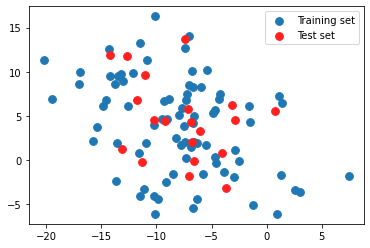

In [38]:
from sklearn.datasets import make_blobs, make_classification

# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=4)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.2
)
plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], color=mglearn.cm2(1), label="Test set", s=60
)
plt.legend(loc="upper right");

Let's transform the data using `StandardScaler` and examine how the data looks like. 

In [39]:
scaler = StandardScaler()
train_transformed = scaler.fit_transform(X_train_toy)
test_transformed = scaler.transform(X_test_toy)

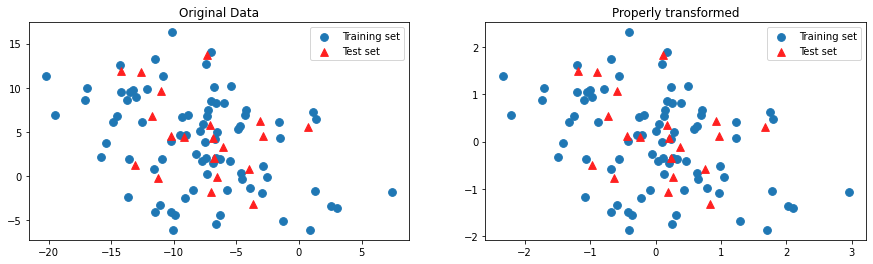

In [40]:
plot_original_scaled(X_train_toy, X_test_toy, train_transformed, test_transformed)

#### Bad methodology 1: Scaling the data separately (for class discussion)

In [41]:
# DO NOT DO THIS! For illustration purposes only.
scaler = StandardScaler()
scaler.fit(X_train_toy)
train_scaled = scaler.transform(X_train_toy)

scaler = StandardScaler()  # Creating a separate object for scaling test data
scaler.fit(X_test_toy)  # Calling fit on the test data
test_scaled = scaler.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data

knn = KNeighborsClassifier()
knn.fit(train_scaled, y_train_toy)
print(f"Training score: {knn.score(train_scaled, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_scaled, y_test_toy):.2f}")

Training score: 0.75
Test score: 0.50


- Is anything wrong in methodology 1? If yes, what is it?  

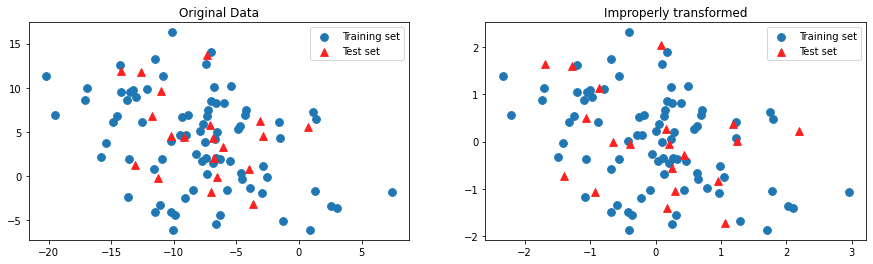

In [42]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    train_scaled,
    test_scaled,
    title_transformed="Improperly transformed",
)

#### Bad methodology 2: Scaling the data together (for class discussion)

In [43]:
X_train_toy.shape, X_test_toy.shape

((80, 2), (20, 2))

In [44]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

(100, 2)

In [45]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:80]
XX_test = XX_scaled[80:]

In [46]:
knn = KNeighborsClassifier()
knn.fit(XX_train, y_train_toy)
print(f"Training score: {knn.score(XX_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test_toy):.2f}")  # Misleading score

Training score: 0.75
Test score: 0.55


- Is anything wrong in methodology 2? If yes, what is it? 

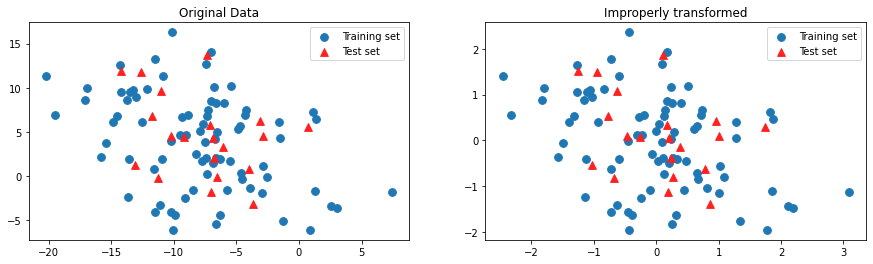

In [47]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    XX_train,
    XX_test,
    title_transformed="Improperly transformed",
)

Not a big difference in the transformed data but if the test set is large it might influence the mean and standard deviation significantly. 

#### Methodology 3: Cross validation with already preprocessed data (for class discussion)

In [48]:
knn = KNeighborsClassifier()

scaler = StandardScaler()
scaler.fit(X_train_toy)
X_train_scaled = scaler.transform(X_train_toy)
X_test_scaled = scaler.transform(X_test_toy)
scores = cross_validate(knn, X_train_scaled, y_train_toy, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000455,0.001269,0.6875,0.671875
1,0.000592,0.000870,0.7500,0.671875
2,0.000642,0.001271,0.6875,0.734375
3,0.000443,0.000884,0.6250,0.750000
4,0.000374,0.000974,0.5000,0.687500


- Is there anything wrong in methodology 3? Are we breaking the golden rule here?  

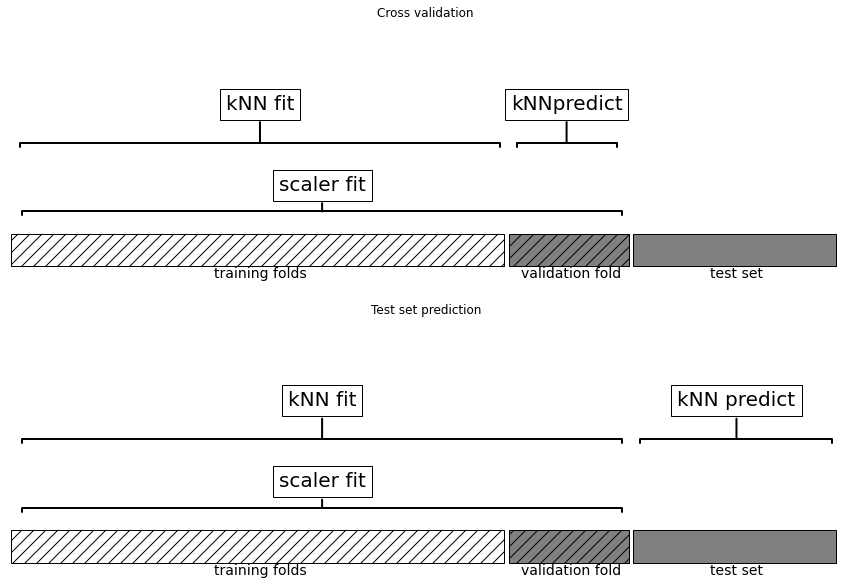

In [49]:
plot_improper_processing("kNN")

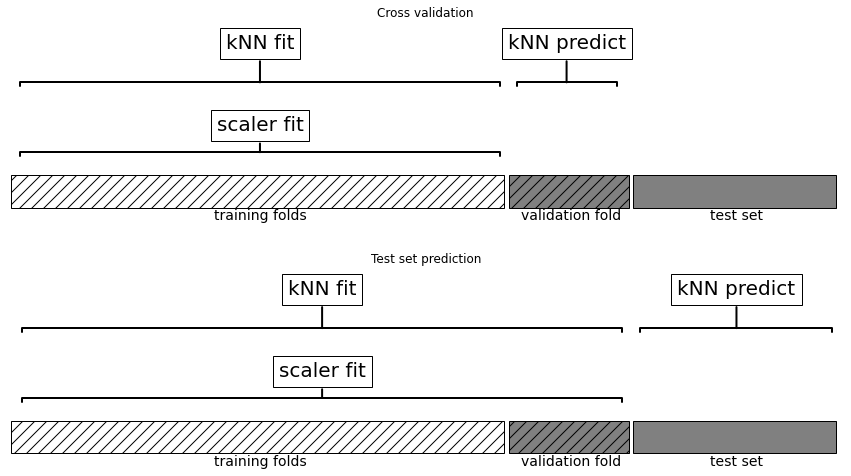

In [50]:
plot_proper_processing("kNN")

<br><br><br><br>

## Feature transformations and the golden rule

### How to carry out cross-validation? 

- Last week we saw that cross validation is a better way to get a realistic assessment of the model. 
- Let's try cross-validation with transformed data. 

In [51]:
knn = KNeighborsRegressor()

scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
scores = cross_validate(knn, X_train_scaled, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.020286,0.228168,0.710905,0.803734
1,0.014352,0.198796,0.706893,0.803212
2,0.013560,0.198202,0.711039,0.803030
3,0.015382,0.231230,0.695769,0.806275
4,0.040414,0.170938,0.697941,0.805146


- Do you see any problem here? 
- Are we applying `fit_transform` on train portion and `transform` on validation portion in each fold?  
    - Here you might be allowing information from the validation set to **leak** into the training step.

- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information.


- In these examples our test accuracies look fine, but our methodology is flawed.
- Implications can be significant in practice!

### Pipelines

Can we do this in a more elegant and organized way?

- YES!! Using [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allows you to define a "pipeline" of transformers with a final estimator.

Let's combine the preprocessing and model with pipeline

In [52]:
### Simple example of a pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor()),
    ]
)

- Syntax: pass in a list of steps.
- The last step should be a **model/classifier/regressor**.
- All the earlier steps should be **transformers**.

### Alternative and more compact syntax: `make_pipeline`

- Shorthand for `Pipeline` constructor
- Does not permit naming steps
- Instead the names of steps are set to lowercase of their types automatically; `StandardScaler()` would be named as `standardscaler`

In [53]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

- Note that we are passing `X_train` and **not** the imputed or scaled data here. 

When you call `fit` on the pipeline, it carries out the following steps:

- Fit `SimpleImputer` on `X_train`
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Fit `StandardScaler` on `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`


In [55]:
pipe.predict(X_train)

array([122460., 115220., 216940., ..., 240420., 254500.,  60420.])

Note that we are passing original data to `predict` as well. This time the pipeline is carrying out following steps:
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Predict using the fit model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`. 

<img src='./img/pipeline.png' width="800">
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

### Let's try cross-validation with our pipeline 

In [56]:
results_dict["imp + scaling + knn"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True
)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.000 (+/- 0.000),-0.055 (+/- 0.012),-0.055 (+/- 0.001)
imp + scaling + knn,0.037 (+/- 0.013),0.221 (+/- 0.023),0.706 (+/- 0.006),0.806 (+/- 0.005)


Using a `Pipeline` takes care of applying the `fit_transform` on the train portion and only `transform` on the validation portion in each fold.   

## Break (5 min)

![](img/eva-coffee.png)


## Categorical features [[video](https://youtu.be/2mJ9rAhMMl0)]

- Recall that we had dropped the categorical feature `ocean_proximity` feature from the dataframe. But it could potentially be a useful feature in this task. 

- Let's create our `X_train` and and `X_test` again by keeping the feature in the data. 

In [57]:
X_train = train_df.drop(columns=["median_house_value"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value"])
y_test = test_df["median_house_value"]

- Let's try to build a `KNeighborRegressor` on this data using our pipeline

In [58]:
# pipe.fit(X_train, X_train)  # fails

- This failed because we have non-numeric data. 
- Imagine how $k$-NN would calculate distances when you have non-numeric features.

### Can we use this feature in the model? 
- In `scikit-learn`, most algorithms require numeric inputs.
- Decision trees could theoretically work with categorical features.  
    - However, the sklearn implementation does not support this. 

### What are the options? 

- Drop the column (not recommended)
    - If you know that the column is not relevant to the target in any way you may drop it. 
- We can transform categorical features to numeric ones so that we can use them in the model.     
    - [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (occasionally recommended)
    - One-hot encoding (recommended in most cases) (this lecture)

In [59]:
X_toy = pd.DataFrame(
    {
        "language": [
            "English",
            "Vietnamese",
            "English",
            "Mandarin",
            "English",
            "English",
            "Mandarin",
            "English",
            "Vietnamese",
            "Mandarin",
            "French",
            "Spanish",
            "Mandarin",
            "Hindi",
        ]
    }
)
X_toy

,language
0,English
1,Vietnamese
2,English
3,Mandarin
4,English
5,English
6,Mandarin
7,English
8,Vietnamese
9,Mandarin


### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels. 
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [60]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
df = pd.DataFrame(
    data=X_toy_ord,
    columns=["language_enc"],
    index=X_toy.index,
)
pd.concat([X_toy, df], axis=1)

,language,language_enc
0,English,0.0
1,Vietnamese,5.0
2,English,0.0
3,Mandarin,3.0
4,English,0.0
5,English,0.0
6,Mandarin,3.0
7,English,0.0
8,Vietnamese,5.0
9,Mandarin,3.0


What's the problem with this approach? 
- We have imposed ordinality on the categorical data.
- For example, imagine when you are calculating distances. Is it fair to say that French and Hindi are closer than French and Spanish? 
- In general, label encoding is useful if there is ordinality in your data and capturing it is important for your problem, e.g., `[cold, warm, hot]`. 

#### One-hot encoding (OHE)
- Create new binary columns to represent our categories.
- If we have $c$ categories in our column.
    - We create $c$ new binary columns to represent those categories.
- Example: Imagine a language column which has the information on whether you 

- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do so.

```{note}
One-hot encoding is called one-hot because only one of the newly created features is 1 for each data point. 
```

In [61]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
enc.fit(X_toy)
X_toy_ohe = enc.transform(X_toy)
pd.DataFrame(
    data=X_toy_ohe,
    columns=enc.get_feature_names(["language"]),
    index=X_toy.index,
)

/home/moveisi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,language_English,language_French,language_Hindi,language_Mandarin,language_Spanish,language_Vietnamese
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0,0.0,0.0


### Let's do it on our housing data

In [62]:
ohe = OneHotEncoder(sparse=False, dtype="int")
ohe.fit(X_train[["ocean_proximity"]])
X_imp_ohe_train = ohe.transform(X_train[["ocean_proximity"]])

- We can look at the new features created using `categories_` attribute

In [63]:
ohe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [64]:
transformed_ohe = pd.DataFrame(
    data=X_imp_ohe_train,
    columns=ohe.get_feature_names(["ocean_proximity"]),
    index=X_train.index,
)
transformed_ohe

/home/moveisi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
6051,0,1,0,0,0
20113,0,1,0,0,0
14289,0,0,0,0,1
13665,0,1,0,0,0
14471,0,0,0,0,1
...,...,...,...,...,...
7763,1,0,0,0,0
15377,1,0,0,0,0
17730,1,0,0,0,0
15725,0,0,0,1,0


```{seealso} 
One-hot encoded variables are also referred to as **dummy variables**. 
You will often see people using [`get_dummies` method of pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to convert categorical variables into dummy variables. That said, using `sklearn`'s `OneHotEncoder` has the advantage of making it easy to treat training and test set in a consistent way.  
```

### ❓❓ Questions for class discussion 

#### True/False: Pipelines and one-hot encoding

1. You can "glue" together imputation and scaling of numeric features and `scikit-learn` classifier object within a single pipeline.  
2. You can "glue" together scaling of numeric features, one-hot encoding of categorical features, and `scikit-learn` classifier object within a single pipeline.  
3. Once you have a `scikit-learn` pipeline object you can call `fit`, `predict`, and `score` on it.


#### More True/False on pipelines and one-hot encoding

4. You can carry out data splitting within `scikit-learn` pipeline. 
5. We have to be careful of the order we put each transformation and model in a pipeline.
6. Pipelines will `fit` and `transform` on the training fold and only `transform` on the validation fold during cross-validation.

## What did we learn today? 

- Motivation for preprocessing
- Common preprocessing steps
    - Imputation 
    - Scaling
    - One-hot encoding
- Golden rule in the context of preprocessing
- Building simple supervised machine learning pipelines using `sklearn.pipeline.make_pipeline`. 

### Problem: Different transformations on different columns
- How do we put this together with other columns in the data before fitting the regressor? 
- Before we fit our regressor, we want to apply different transformations on different columns 
    - Numeric columns
        - imputation 
        - scaling         
    - Categorical columns 
        - imputation 
        - one-hot encoding        

**Coming up: sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)!!** 